In [1]:
import coolingFunction

In [2]:
import copy
import numpy as np
import h5py
import scipy
import scipy.special
import sys
import verdict
import os
import tqdm
import unyt

In [3]:
import kalepy as kale

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import matplotlib.gridspec as gridspec
import matplotlib.transforms
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [6]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [7]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

In [8]:
import trove

# Load Data

In [9]:
pm = dict(
    snum = 600,
    tables_dir = '/work/03057/zhafen/CoolingTables/',
    study_duplicates = False,
    ahf_index = 600,
    
    # If we want to ensure some minimum number of snapshots in the galaxy after accreting
    # (remember to account for the last 10 snapshots with small dt)
    minInd = 0,
    maxInd = 54, # Corresponds to 1 Gyr. We don't look at accretion prior.
    
    # For the fancy scatter plot we're visualizing.
    variable_alpha = True,
)

In [10]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    script_id = 'nb.8',
    variation = 'm12i_md',
    global_variation = '',
    **pm
)

In [11]:
# Used so often it's nice to not enclose
snum = pm['snum']
ind = pm['ahf_index'] - snum

In [12]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['base_data_dir'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [13]:
w.retrieve_halo_data()

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1168: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.halo_coords = halo_coords_comoving * scale_factor_and_hinv[np.newaxis, :]


In [14]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.0


In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [16]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

In [17]:
base_processed_data_dir = pm['config_parser'].get( 'DEFAULT', 'processed_data_dir' )
default_data_fp = os.path.join( base_processed_data_dir, 'summary.hdf5' )
default_data = verdict.Dict.from_hdf5( default_data_fp, create_nonexistent=True )

In [18]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_fp, create_nonexistent=True )

## Labels

In [19]:
tchange_key = pm['central_indices'].split( '_' )[0]
t_tchange_key = 't_' + tchange_key

In [20]:
if pm['central_indices'] == 't1e5_inds':
    t_tchange_label = r'time relative to cooling, $t - t_{T=10^5{\rm K}}$ [Myr]'
    rchange_label = r'$R(t_{T=10^5{\rm K}})$'
elif pm['central_indices'] == 'tacc_inds':
    t_tchange_label = r'time relative to accretion, $t - t_{\rm acc}$ [Myr]'
    rchange_label = r'$R(t_{\rm acc})$'
else:
    t_tchange_label = pm['central_indices']

# Data Pre-Processing

## Calculate $\theta$
Also called $\phi$...

In [21]:
tot_momentum_fp = os.path.join( base_processed_data_dir, 'tot_momentums.hdf5' )
tot_ang_momentum = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]

In [ ]:
w.tot_ang_momentum = tot_ang_momentum

In [22]:
w.calc_abs_phi()

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if normal_vector == 'total ang momentum':
/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1497: RuntimeWarning: invalid value encountered in arccos
  phi_all[:,i] = np.arccos( cos_phi ) * 180. / np.pi


## Calculate $\vec j$

In [23]:
specific_mom = w.get_data( 'J' )
w.data['Jmag'] = w.get_data( 'Jmag' )

In [24]:
tot_ang_momentum_normed = tot_ang_momentum / np.linalg.norm( tot_ang_momentum )
w.data['Jz'] = np.array([ np.dot( specific_mom[:,:,i].transpose(), tot_ang_momentum_normed ) for i in range( w.snums.size ) ]).transpose()

In [25]:
w.data['Jz/J'] = w.data['Jz'] / w.data['Jmag']

## Calculate mass deposition

In [26]:
delta_m = w.get_data( 'M' )[:,:-1] - w.get_data( 'M' )[:,1:]
deposited_m = np.ma.masked_array( delta_m, delta_m<0 ).sum( axis=1 ).data

## Calculate central indices

In [21]:
# Calculate central indices
inds = w.get_data( pm['central_indices'] )

100%|██████████| 80211/80211 [00:10<00:00, 7447.28it/s]


# Analysis

In [28]:
# Setup axes
t_window = 1.
t = w.get_data( 'time' )
x_range = [ t[ind] - t_window, t[ind] ]

In [29]:
t_snaps = t[( t > x_range[0] ) & ( t < x_range[1] )][::-1]

In [30]:
n_snaps = t_snaps.size

In [31]:
dt = t_snaps[1:] - t_snaps[:-1]

In [32]:
t_bins = np.zeros( ( t_snaps.size + 1, ) )
t_bins[1:-1] = t_snaps[:-1] + dt / 2.
t_bins[0] = t_snaps[0] - dt[0] / 2.
t_bins[-1] = t_snaps[-1] + dt[-1] / 2.

In [33]:
   
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )

# Median and interval stats
logT = np.log10( w.get_selected_data( 'T', compress=False ) )#[:,ind:ind+n_snaps+1]
R = w.get_selected_data( 'R', compress=False )#[:,ind:ind+n_snaps+1]
L = w.get_selected_data( 'Lmag', compress=False )#[:,ind:ind+n_snaps+1]
M = w.get_selected_data( 'M', compress=False )#[:,ind:ind+n_snaps+1]

logT_med = np.nanmedian( logT, axis=0 )
R_med = np.nanmedian( R, axis=0 )

logT_low = np.nanpercentile( logT, 16, axis=0 )
logT_high = np.nanpercentile( logT, 84, axis=0 )

R_low = np.nanpercentile( R, 16, axis=0 )
R_high = np.nanpercentile( R, 84, axis=0 )

inds = w.get_data( pm['central_indices'] )
particle_inds = np.arange( inds.size )

valid = ( inds >= pm['minInd'] ) & ( inds < pm['maxInd'] )
R_at_tchange = R[particle_inds[valid],inds[valid]]
M_at_tchange = M[particle_inds[valid],inds[valid]]
L_at_tchange = R[particle_inds[valid],inds[valid]]
R_rgal_at_tchange = R[particle_inds[valid],inds[valid]] / w.r_gal[inds[valid]]
t_at_tchange = t[inds[valid]]

# R_at_tchange = np.array( [ R[i, ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]
# M_at_tchange = np.array( [ M[i, ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]
# L_at_tchange = np.array( [ L[i, ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]
# R_rgal_at_tchange = np.array( [ R[i, ind]/w.r_gal[ind] for i, ind in enumerate( inds ) ] )[inds >= pm['minInd']]

# t_at_tchange = np.array( [ t[ind] for ind in inds ] )[inds >= pm['minInd']]


/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


## Store for Later Use

In [34]:
# Store R for later use
r_vir = w.r_vir[snum]
r_points, r_pdf = kale.density(
    R_at_tchange[np.invert(np.isnan(R_at_tchange))],
    points = np.linspace( 0., r_vir, 512 ),
    probability = True,
    reflect = [ 0., None ],
)

In [35]:
data_to_store = {
    'points': r_points,
    'pdf': r_pdf,
    'median': np.nanmedian( R_at_tchange ),
    '16th_percentile': np.nanpercentile( R_at_tchange, 16 ),
    '84th_percentile': np.nanpercentile( R_at_tchange, 84 ),
}

/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [36]:
# Store radius for later use
flag = pm['central_indices'].split( '_' )[0][1:]
r_key = 'R' + flag
if not r_key in data.keys():
    data[r_key] = {}
for key, item in data_to_store.items():
    if key not in data[r_key]:
        data[r_key][key] = {}
    data[r_key][key][pm['variation']] = item

In [37]:
# Store R for later use
r_vir = w.r_vir[snum]
r_points, r_pdf = kale.density(
    R_rgal_at_tchange[np.invert(np.isnan(R_rgal_at_tchange))],
    points = np.linspace( 0., r_vir / w.r_gal[0], 512 ),
    probability = True,
    reflect = [ 0., None ],
)

In [38]:
data_to_store = {
    'points': r_points,
    'pdf': r_pdf,
    'median': np.nanmedian( R_rgal_at_tchange ),
    '16th_percentile': np.nanpercentile( R_rgal_at_tchange, 16 ),
    '84th_percentile': np.nanpercentile( R_rgal_at_tchange, 84 ),
}

/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [39]:
# Store radius relative to galaxy radius for later use
rrgal_key = r_key + '_rgal'
if not rrgal_key in data.keys():
    data[rrgal_key] = {}
for key, item in data_to_store.items():
    if key not in data[rrgal_key]:
        data[rrgal_key][key] = {}
    data[rrgal_key][key][pm['variation']] = item

In [40]:
# Store number of particles tracked
if not 'n_tracked' in data.keys():
    data['n_tracked'] = {}
data['n_tracked'][pm['variation']] = w.n_particles

In [41]:
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

Stored summary data at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/summary.hdf5


## Accretion Tracks and $R_{\rm change}$ Distribution

In [42]:
dt_before = -1.
dt_after = 0.5
color_dt = 0.2
n_particles = 5
x_lim = np.array( [ 0, 105 ] )
y_lim = np.array( [ 5e3, 5e6 ] )
y2_lim = np.array( [ 1, 1e2 ] )

/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median R_at_tchange = 0.0536 Rvir


/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/plot_data/plotting.py:324: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = fig_or_ax.add_axes(ax_location)
<ipython-input-43-1ce079034071>:191: RuntimeWarning: divide by zero encountered in log10
  np.log10( k_arr ),
<ipython-input-43-1ce079034071>:191: RuntimeWarning: divide by zero encountered in log10
  np.log10( k_arr ),


File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/tracks/tracks_m12i_md.pdf


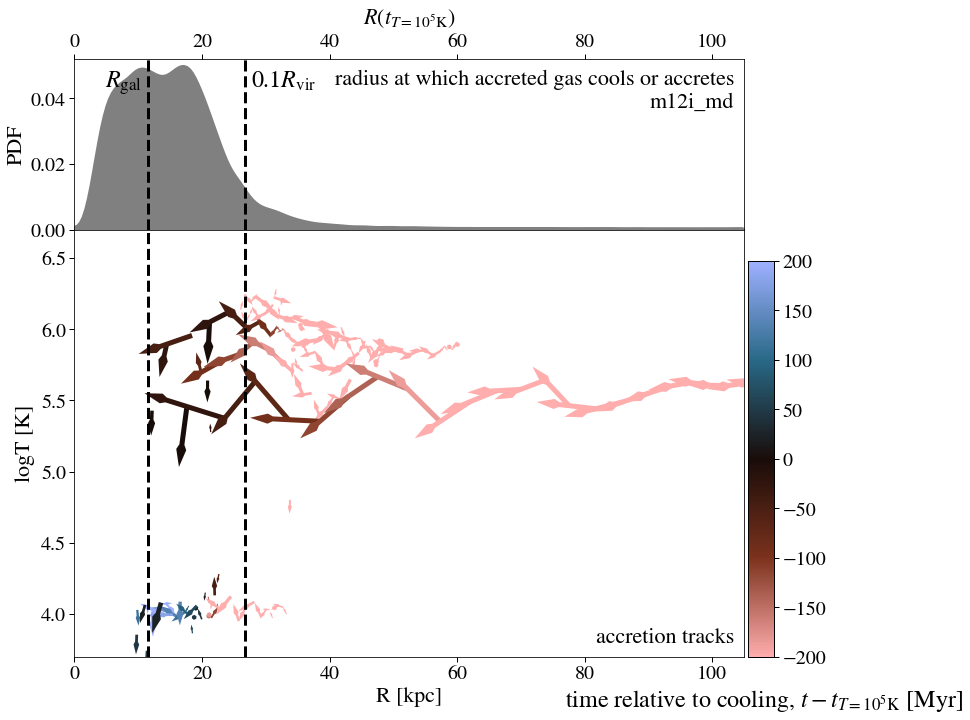

In [43]:
%matplotlib inline

# Load sim data

w.data_masker.clear_masks()

# Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'n_out', -1, 1 )

np.random.seed( 4 )

fig = plt.figure( figsize=(12, 11), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec(7, 1)
gs.update( hspace=0.001 )

ax1 = plt.subplot(gs[:2,0])

r_for_hist = copy.copy( R_at_tchange )
r_for_hist[r_for_hist>x_lim[1]] = x_lim[1]*.99
bins = np.linspace( x_lim[0], x_lim[1], 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

r_points, r_pdf = kale.density(
    r_for_hist[np.invert(np.isnan(r_for_hist))],
    points = centers,
    probability = True,
    reflect = [ 0., None ],
)
ax1.fill_between(
    r_points,
    r_pdf,
    color = '0.5',
    linewidth = 5,
)

# n, bins, patches = ax1.hist(
#     r_for_hist,
#     bins = ,
#     color = '0.5',
#     density = True,
# )

print( 'Median R_at_tchange = {:.3g} Rvir'.format( np.nanmedian( R_at_tchange ) / r_vir ) )

# Don't do the below, because it's so far out that it's not visible
# Create plot for volume filling distribution
#     n_rand = int( 1e5 )
#     data_coords = np.random.uniform( -r_vir, r_vir, (3, n_rand ) )
#     data_r = np.sqrt( ( data_coords ** 2. ).sum( axis=0 ) )
#     filtered_data_r = data_r[data_r<r_vir]
#     ax1.hist(
#         filtered_data_r,
#         bins = bins,
#         color = 'k',
#         density = True,
#         histtype = 'step',
#         linewidth = 3,
#         linestyle = '--',
#     )

# ax.axvline(
#     np.median( R_at_tchange ),
#     color = 'k',
# )

# ax1.axvline(
#     w.r_gal[0],
#     color = 'k',
#     linestyle = '--',
#     linewidth = 3,
# )

ax1.set_xlim( x_lim )
ax1.set_ylim( 0, r_pdf.max()*1.05 )

ax1.set_xlabel( rchange_label, fontsize=22, labelpad=10 )
ax1.xaxis.set_label_position( 'top' )
ax1.set_ylabel( 'PDF', fontsize=22, )

ax1.tick_params( axis='x', top=True, labeltop=True, bottom=False, labelbottom=False )
# ax1.tick_params( axis='y', left=False, labelleft=False, )

ax1.annotate(
    text='radius at which accreted gas cools or accretes\n{}'.format( pm['variation'] ),
    xy=(1,1),
    xycoords='axes fraction',
    xytext=(-10,-10),
    textcoords='offset points',
    ha = 'right',
    va = 'top',
    fontsize = 22,
)


### FLOW PLOT ####

ax2 = plt.subplot(gs[2:,0])
ax3 = ax

# Choose particles
particle_inds = np.random.choice( np.arange( w.n_particles ), size=n_particles, replace=False )

# Get the time at the phase
t_min_tchange = w.get_data( t_tchange_key )

# Get positions in r-T space and color
valid_value = ( t_min_tchange < dt_after ) & ( t_min_tchange > dt_before )
valid_value = valid_value & ( w.get_data( 'n_out' ) == 0 )
valid_value_inds = valid_value[particle_inds]
r_vecs_all = w.get_data( 'R' )[particle_inds]
T_vecs_all = w.get_data( 'T' )[particle_inds]
K_vecs_all = w.get_data( 'entropy' )[particle_inds ]

# Plot quivers for each particles
for k, particle_ind in enumerate( particle_inds ):

    # Format for quiver
    r_vecs = r_vecs_all[k][valid_value_inds[k]]
    T_vecs = np.log10( T_vecs_all[k][valid_value_inds[k]] )
    K_vecs = np.log10( K_vecs_all[k][valid_value_inds[k]] )
    x = r_vecs[1:]
    y = T_vecs[1:]
    y2 = K_vecs[1:]
    dx = r_vecs[:-1] - r_vecs[1:]
    dy = T_vecs[:-1] - T_vecs[1:]
    dy2 = K_vecs[:-1] - K_vecs[1:]
    angles_deg = np.arctan2( dy, dx ) * 180. / np.pi
    C = t_min_tchange[particle_inds][k,valid_value_inds[k]][1:] * 1e3

    # Plot quiver
    quiver = ax2.quiver(
        x, y,
        dx, dy,
        C,
        angles = 'xy',
        units = 'y',
        scale = 10,
        minshaft = 2,
        headwidth = 2,
        headlength = 3.5,
#             color = 'red',
        cmap = palettable.scientific.diverging.Berlin_5_r.mpl_colormap,
        norm = plt.Normalize( -color_dt*1e3, color_dt*1e3 ),
    )
    plotting.add_colorbar(
        fig,
#             ax2,
        quiver,
        ax_location = [0.905, 0.125, 0.03, 0.5],
#             method = 'ax',
    )

#     w_plotter.plot_streamlines(
#         ax = ax2,
#         x_key = 'R',
#         y_key = 'logT',
#         start_ind = ind,
#         end_ind = 'time_based',
#         t_end = 5.,
#         sample_inds = particle_inds,
#         sample_selected_interval = False,
# #         x_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
# #         y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 7 },
#         color = 'black',
#         fade_color = 'black',
#         min_fade_linewidth = 0.5,
#     #     fade_streamlines = False,
#     #     line_features = gas_to_star_line_features,
#         linewidth = 1,
#         x_label = 'R (kpc)',
#         y_label = 'logT (K)',
#     #     y_scale = 'log',
#         x_range = [ 0, 100. ],
#         y_range = [ 3.5, 6.9 ],
#     #     y_floor = 10.**3.8,
#     )

# Plot reference entropy lines
r = w.get_data( 'R' )
at_border = ( r < 1.1 * x_lim[1] ) & ( r > 0.9 * x_lim[1] ) & valid_value
k_at_border = w.get_data( 'entropy' )[at_border]
med_k_at_border = np.nanmedian( k_at_border )
a_vals = [ 0, 1, 2 ]
r_arr = np.linspace( x_lim[0], x_lim[1], 256 )
k_arrs = [ med_k_at_border * ( r_arr / x_lim[1] )**a for a in a_vals ]
for m, k_arr in enumerate( k_arrs ):
    ax3.plot(
        r_arr,
        np.log10( k_arr ),
        color = '0.25',
        linewidth = 1.5,
#             linestyle = '--',
    )
    ax3.annotate(
        text = r'$\propto r^{' + str( a_vals[m] ) + r'}$',
        xy = ( r_arr[100], np.log10( k_arr[100] ) ),
        xycoords = 'data',
        xytext = ( 0, 0 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'bottom',
        fontsize = 24,
        color = '0.25',
    )

# # Time
# ax.plot(
#     R_med,
#     logT_med,
#     linewidth = 3,
#     color = 'b',
# )
# ax.fill_between(
#     R_med,
#     logT_low,
#     logT_high,
#     color = 'b',
#     alpha = 0.25,
# )

for ax_k in [ ax2, ax3 ]:
    ax_k.annotate(
        text = 'accretion tracks',
        xy=(1,0),
        xycoords='axes fraction',
        xytext=(-10,10),
        textcoords='offset points',
        ha = 'right',
        va = 'bottom',
        fontsize = 22,
    )

t_label = ax2.annotate(
    text = t_tchange_label,
    xy = ( 1, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -30 ),
    textcoords = 'offset points',
    ha = 'center',
    va = 'top',
    fontsize = 24,
)

# Radius lines
for ax_k in [ ax1, ax2, ax3 ]:
    ax_k.axvline(
        0.1 * r_vir,
        color = 'k',
        linestyle = '--',
        linewidth = 3,
    )
#     ax_k.axvline(
#         r_vir,
#         color = 'k',
#         linestyle = '--',
#         linewidth = 3,
#     )
    ax_k.axvline(
        w.r_gal[ind],
        color = 'k',
        linestyle = '--',
        linewidth = 3,
    )
    if ax_k.is_first_row():
        trans = matplotlib.transforms.blended_transform_factory( ax_k.transData, ax_k.transAxes )
        ax_k.annotate(
            text = r'$0.1 R_{\rm vir}$',
            xy = ( 0.1 * r_vir, 1.0 ),
            xycoords = trans,
            xytext = ( 6, -10 ),
            textcoords = 'offset points',
            ha = 'left',
            va = 'top',
            fontsize = 24,
        )
        ax_k.annotate(
            text = r'$ R_{\rm gal}$',
            xy = ( w.r_gal[ind], 1.0 ),
            xycoords = trans,
            xytext = ( -6, -10 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 24,
        )

# Remove bottom ticks on middle axis
#     ax2.tick_params( axis='x', bottom=False, labelbottom=False )

ax2.set_xlim( x_lim )
ax2.set_ylim( np.log10( y_lim ) )
ax2.set_ylabel( '$\log$T [K]', fontsize=22 )
ax3.set_xlim( x_lim )
ax3.set_ylim( np.log10( y2_lim) )
ax2.set_xlabel( 'R [kpc]', fontsize=22 )
ax3.set_ylabel( r'$\log$K [Kev cm$^2$]', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'tracks' ),
    save_file = 'tracks_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)


## Angular Distribution

In [44]:
bins = np.linspace( -1., 1., 128 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

In [45]:
dt = 0.1
t_tchange_centers = np.arange( -1.0, 0.5 + 0.01, 0.01 )

In [46]:
def calc_sph_harm_moment( l, m, phi, masses, radii ):
    
    prefactor = np.sqrt( 4. * np.pi / (2. * l + 1) )
    ylm = scipy.special.sph_harm( m, l, 0., phi ).real
    to_sum = masses * radii**l * ylm
    
    return prefactor * to_sum.sum()

In [47]:
# Get the time at the phase
t_tchange = w.get_data( t_tchange_key )
t_tchange_flat = t_tchange.flatten()
t_post_inds = np.argmin( np.abs( t_tchange - 0.150 ), axis=1 )
t_pre_inds = np.argmin( np.abs( t_tchange + 0.150 ), axis=1 )
insufficient_time_after = t_post_inds == 0
insufficient_time_after_mask = np.tile( insufficient_time_after, ( w.n_snaps, 1 ) ).transpose()

In [48]:
# Mask Data
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )
w.data_masker.mask_data( 'insufficient_time_after', custom_mask=insufficient_time_after_mask,  )

In [49]:
# Get data
phi = w.get_selected_data( 'Phi', compress=False ).flatten()
r_scale = np.full( w.n_snaps, np.nan )
r_scale[:w.r_gal.size] = w.r_gal
radii = ( w.get_selected_data( 'R', compress=False ) / r_scale ).flatten()
masses = w.get_selected_data( 'M', compress=False ).flatten()

In [ ]:
# Get distributions
cosphi_dists = []
cosphi_pdfs = []
cosphi_16ths = []
cosphi_84ths = []
cosphi_stds = []
q20 = []
q33 = []
for i, center in enumerate( tqdm.tqdm( t_tchange_centers ) ):
    bin_low = center - dt / 2.
    bin_high = center + dt / 2.
    in_bin = ( t_tchange_flat > bin_low ) & ( t_tchange_flat < bin_high )
    
    phi_arr = phi[in_bin]
    phi_arr_rad = phi_arr * np.pi / 180.
    cosphi_arr = np.cos( phi_arr_rad )
    cosphi_points, cosphi_pdf = kale.density(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        points = centers,
        probability = True,
        reflect = [ -1., 1. ],
    )
    cosphi_hist, cosphi_bins = np.histogram(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        bins = bins,
        density = True,
    )
    cosphi_pdfs.append( cosphi_pdf )
    cosphi_dists.append( cosphi_hist )
    
    cosphi_arr_comp = cosphi_arr.compressed()
    cosphi_16ths.append( np.nanpercentile( cosphi_arr_comp, 16 ) )
    cosphi_84ths.append( np.nanpercentile( cosphi_arr_comp, 84. ) )
    cosphi_stds.append( np.nanstd( cosphi_arr_comp ) )
    
    masked = np.invert( radii.mask ) & in_bin
    q20_i = calc_sph_harm_moment(
        2,
        0,
        phi[masked].compressed(),
        masses[masked].compressed(),
        radii[masked].compressed()
    )
    q20.append( q20_i )
    q33_i = calc_sph_harm_moment(
        3,
        3,
        phi[masked].compressed(),
        masses[masked].compressed(),
        radii[masked].compressed()
    )
    q33.append( q33_i )

 99%|█████████▉| 150/151 [04:17<00:02,  2.49s/it]

In [ ]:
labeled_is = np.arange( 0, 150, 10 )

In [ ]:
fig = plt.figure( figsize=(10, 4.5 ), facecolor='w' )
ax = plt.gca()

z_max = t_tchange_centers.max()
z_min = t_tchange_centers.min()
        
for i, cosphi_dist in enumerate( cosphi_dists ):

    z_width = z_max - z_min
    color_value = ( t_tchange_centers[i] - z_min )/z_width
    color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )

    if i in labeled_is:
        if np.isclose( t_tchange_centers[i], 0. ):
            t_tchange_centers[i] = 0
        label = (
            '{:.3g}'.format( t_tchange_centers[i]*1e3 ) +
            r' Myr'
        )
    else:
        continue

    line = ax.plot(
        centers,
        cosphi_dist, #/ (np.pi / 180. / 2. * np.sin( bin_centers * np.pi/180. ) ),
        linewidth = 1.5,
        color = color,
        label = label,
#             zorder = 10 - i,
    )

ax.tick_params(
    axis = 'x',
    top = True,
    labeltop = ax.is_first_row(),
    bottom = ax.is_last_row(),
    labelbottom = ax.is_last_row(),
)

ax.axhline(
    0.5,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)
ax.axvline(
    0,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)

# Sim name label
ax.annotate(
    text = pm['variation'],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -20 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 26,
)

# line labels
ax.annotate(
    text = 'spherical\ndistribution',
    xy = ( -1, 0.5 ),
    xycoords = 'data',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 22,
)
ax.annotate(
    text = 'disc\ndistribution',
    xy = ( 0, 3.75 ),
    xycoords = 'data',
    xytext = ( 15, -10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 22,
)

t_label = ax.annotate(
    text = t_tchange_label,
    xy = ( 1, 0.875 ),
    xycoords = 'axes fraction',
    xytext = ( -25, 0 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = 24,
)
t_label.set_zorder( 1000 )
ax.legend(
    prop={'size': 17},
    loc = 'center right',
)

ax.set_xlim( -1, 1 )
ax.set_ylim( 0, 3.75 )

ax.set_xlabel( r'$\cos\ \theta$', fontsize=22 )
# if ax.is_first_row():
#     ax.xaxis.set_label_position( 'top' )
ax.set_ylabel( r'PDF$\ (\cos\ \theta$)', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'ang_dist_evolution' ),
    save_file = 'theta_vs_t_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

### Store phis

In [ ]:
zero_ind = np.argmin( np.abs( centers ) )
pdf_at_zero = np.array( cosphi_dists )[:,zero_ind]

In [ ]:
data_to_store = {
    'points': centers,
    't_tchange_centers': t_tchange_centers,
    'pdf': np.array( cosphi_pdfs ),
    'hist': np.array( cosphi_dists ),
    '16th_percentile': cosphi_16ths,
    '84th_percentile': cosphi_84ths,
    'std': cosphi_stds,
    'pdf(cos theta=0)': pdf_at_zero,
    'q20': q20,
    'q33': q33,
}

In [ ]:
# Store circularity for later use
if not 'cosphi' in data.keys():
    data['cosphi'] = {}
for key, item in data_to_store.items():
    if key not in data['cosphi']:
        data['cosphi'][key] = {}
    data['cosphi'][key][pm['variation']] = item
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

## Angular Distribution for Momentum

In [ ]:
dt = 0.1
t_tchange_centers = np.arange( -1.0, 0.5 + 0.01, 0.01 )

In [ ]:
# Mask Data
w.data_masker.clear_masks()
w.data_masker.mask_data( 'PType', data_value=0 )
w.data_masker.mask_data( 'insufficient_time_after', custom_mask=insufficient_time_after_mask,  )

In [ ]:
# Calculate angular momentum
ang_mom_dir = tot_ang_momentum / np.linalg.norm( tot_ang_momentum )
j = w.get_selected_data( 'L', )
jz = np.dot( j.transpose(), ang_mom_dir )
jmag = w.get_selected_data( 'Lmag', )
jz_jmag = ( jz / jmag )

In [ ]:
# Get data
phi = np.arccos( jz_jmag ) * 180. / np.pi
r_scale = np.full( w.n_snaps, np.nan )
r_scale[:w.r_gal.size] = w.r_gal
radii = ( w.get_selected_data( 'R', compress=False ) / r_scale ).compressed()
masses = w.get_selected_data( 'M', )

In [ ]:
# Get masking t_tchange
t_tchange_flat = t_tchange[np.invert( w.data_masker.get_mask() )].flatten()

In [ ]:
# Get distributions
cosphi_dists = []
cosphi_pdfs = []
cosphi_16ths = []
cosphi_84ths = []
cosphi_stds = []
for i, center in enumerate( tqdm.tqdm( t_tchange_centers ) ):
    bin_low = center - dt / 2.
    bin_high = center + dt / 2.
    in_bin = ( t_tchange_flat > bin_low ) & ( t_tchange_flat < bin_high )
    
    if in_bin.sum() == 0:
        cosphi_pdfs.append( np.zeros( centers.shape ) )
        cosphi_dists.append( np.zeros( centers.shape ) )
        cosphi_16ths.append( np.nan )
        cosphi_84ths.append( np.nan )
        cosphi_stds.append( np.nan )
        continue
    
    phi_arr = phi[in_bin]
    phi_arr_rad = phi_arr * np.pi / 180.
    cosphi_arr = np.cos( phi_arr_rad )
    cosphi_points, cosphi_pdf = kale.density(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        points = centers,
        probability = True,
        reflect = [ -1., 1. ],
    )
    cosphi_hist, cosphi_bins = np.histogram(
        cosphi_arr[np.invert(np.isnan(cosphi_arr))],
        bins = bins,
        density = True,
    )
    cosphi_pdfs.append( cosphi_pdf )
    cosphi_dists.append( cosphi_hist )
    
    cosphi_16ths.append( np.nanpercentile( cosphi_arr, 16 ) )
    cosphi_84ths.append( np.nanpercentile( cosphi_arr, 84. ) )
    cosphi_stds.append( np.nanstd( cosphi_arr ) )

In [ ]:
labeled_is = []
for i in range( len( cosphi_dists ) ):
    if i % 20 == 0:
        labeled_is.append( i )

In [ ]:
fig = plt.figure( figsize=(10, 4.5 ), facecolor='w' )
ax = plt.gca()

# z_max = t_tchange_centers.max()
z_min = -0.5
z_max = -z_min
        
for i, cosphi_dist in enumerate( cosphi_dists ):

    z_width = z_max - z_min
    color_value = ( t_tchange_centers[i] - z_min )/z_width
    color = palettable.scientific.diverging.Roma_3.mpl_colormap( color_value )
    
    if ( t_tchange_centers[i] < -0.5 ) or ( t_tchange_centers[i] > 0.50 ):
        continue
        
    if i in labeled_is:
        if np.isclose( t_tchange_centers[i], 0. ):
            t_tchange_centers[i] = 0
        label = (
            '{:.3g}'.format( t_tchange_centers[i]*1e3 ) +
            r' Myr'
        )
    else:
        continue

    cosphi_dist = np.cumsum( cosphi_dist )
    cosphi_dist /= cosphi_dist[-1]
    line = ax.plot(
        centers,
        cosphi_dist, #/ (np.pi / 180. / 2. * np.sin( bin_centers * np.pi/180. ) ),
        linewidth = 5,
        color = color,
        label = label,
#             zorder = 10 - i,
    )

ax.tick_params(
    axis = 'x',
    top = True,
    labeltop = ax.is_first_row(),
    bottom = ax.is_last_row(),
    labelbottom = ax.is_last_row(),
)

ax.axhline(
    0.5,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)
ax.axvline(
    0,
    color = '.2',
    linestyle = '-',
    linewidth = 2,
)

# Sim name label
ax.annotate(
    text = pm['variation'],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 20, -20 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 26,
)

# line labels
# ax.annotate(
#     text = 'spherical\ndistribution',
#     xy = ( -1, 0.5 ),
#     xycoords = 'data',
#     xytext = ( 10, 10 ),
#     textcoords = 'offset points',
#     ha = 'left',
#     va = 'bottom',
#     fontsize = 22,
# )
# ax.annotate(
#     text = 'disc\ndistribution',
#     xy = ( 0, 3.75 ),
#     xycoords = 'data',
#     xytext = ( 15, -10 ),
#     textcoords = 'offset points',
#     ha = 'left',
#     va = 'top',
#     fontsize = 22,
# )

t_label = ax.annotate(
    text = t_tchange_label,
    xy = ( 1, 0.875 ),
    xycoords = 'axes fraction',
    xytext = ( -25, 0 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = 24,
)
t_label.set_zorder( 1000 )
ax.legend(
    prop={'size': 17},
    bbox_to_anchor = [ 0.5, 1. ],
    loc = 'upper right',
)

# ax.set_xlim( -1, 1 )
ax.set_xlim( 0.5, 1 )
ax.set_ylim( 0, 1 )
# ax.set_ylim( 0.01, 45 )
# ax.set_yscale( 'log' )

ax.set_xlabel( r'$\cos\ \theta$', fontsize=22 )
# if ax.is_first_row():
#     ax.xaxis.set_label_position( 'top' )
ax.set_ylabel( r'PDF$\ (\cos\ \theta$)', fontsize=22 )

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'ang_dist_evolution' ),
    save_file = 'jzjmag_vs_t_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

### Store phis

In [ ]:
zero_ind = np.argmin( np.abs( centers ) )
pdf_at_zero = np.array( cosphi_dists )[:,zero_ind]

In [ ]:
data_to_store = {
    'points': centers,
    't_tchange_centers': t_tchange_centers,
    'pdf': np.array( cosphi_pdfs ),
    'hist': np.array( cosphi_dists ),
    '16th_percentile': cosphi_16ths,
    '84th_percentile': cosphi_84ths,
    'std': cosphi_stds,
    'pdf(cos theta=0)': pdf_at_zero,
}

In [ ]:
# Store circularity for later use
if not 'jzjmag' in data.keys():
    data['jzjmag'] = {}
for key, item in data_to_store.items():
    if key not in data['jzjmag']:
        data['jzjmag'][key] = {}
    data['jzjmag'][key][pm['variation']] = item
data.to_hdf5( data_fp )
print( 'Stored summary data at {}'.format( data_fp ) )

## Projected Plot

### Settings

In [ ]:
def get_cmap_and_norm( data_key ):

    if data_key == 'T':
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'berlin_white',
            [
                palettable.scientific.diverging.Berlin_3.mpl_colors[0],
                'w',
                palettable.scientific.diverging.Berlin_3.mpl_colors[-1],
            ],
        )
        norm = plt_colors.LogNorm( vmin=1e4, vmax=1e6 )
    elif data_key == 'Jz/J':
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'tofino_white',
            [
                palettable.cartocolors.diverging.Tropic_7.mpl_colors[-2],
                'w',
                palettable.cartocolors.diverging.Tropic_7.mpl_colors[1],
            ],
        )
        norm = plt_colors.Normalize( vmin=-1, vmax=1 )

    return cmap, norm

In [ ]:
cmap, norm = get_cmap_and_norm( 'T' )

### Publication Version

#### Get Data

In [ ]:
if pm['generate_expensive_visualizations']:

    # Mask Data
    w.data_masker.clear_masks()
    w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
    w.data_masker.mask_data( 'PType', data_value=0 )
    w.data_masker.mask_data( 'insufficient_time_after', custom_mask=insufficient_time_after_mask,  )

    pre = {}
    for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T' ]:
        pre[key] = w.get_selected_data( key, compress=False )[np.arange(w.n_particles),t_pre_inds].compressed()

    den_msunkpc3 = ( pre['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
    pre['Vol'] = pre['M'] * unyt.Msun / den_msunkpc3
    pre['h'] = ( 3. * pre['Vol'] / 4. / np.pi )**(1./3.)

    post = {}
    for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T' ]:
        post[key] = w.get_selected_data( key, compress=False )[np.arange(w.n_particles),t_post_inds].compressed()

    den_msunkpc3 = ( post['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
    post['Vol'] = post['M'] * unyt.Msun / den_msunkpc3
    post['h'] = ( 3. * post['Vol'] / 4. / np.pi )**(1./3.)

    prepost_labels = [
        '150 Myrs before changing',
        '150 Myrs after changing',
    ]
    prepost_filetags = [
        'before',
        'after',
    ]

#### Plot

In [ ]:
if pm['generate_expensive_visualizations']:
    for i, d in enumerate( [ pre, post ] ):

        fig = plt.figure( figsize=(12,10), facecolor='k' )
        ax = plt.gca()

        # Point size
        lim = 0.13 * w.r_vir[snum]
        width_in_data = 2 * lim
        width_in_pixels = ax.get_window_extent().width
        pixels_to_points = fig.dpi / 72.
        scale = 10.
        radius = d['h'] * ( width_in_pixels / width_in_data ) * pixels_to_points * scale
        s = ( radius )**2.

        # Colors
        colors = cmap( norm( d['T'] ) )

        # Alpha
        if pm['variable_alpha']:
            column_den = d['M'] / d['h']**2.
            alpha = plt_colors.LogNorm( vmin=np.nanmin( column_den ), vmax=np.nanmax( column_den ) )( column_den ) * 0.065 * ( 50000 / w.n_particles)
            alpha[alpha>1.] = 1.
            alpha[alpha<0.] = 0.
            colors[:,3] = alpha
        else:
            colors[:,3] = 0.01

        # Plot itself
        ax.scatter(
            d['Rx'],
            d['Rz'],
            s = s,
            c = colors,
            edgecolors = 'none',
        )

        # Scale bar
        size = min( 30., 0.95 * lim )
        xy = ( -size, -0.95*lim )
        ax.plot(
            xy[0] + np.array([ 0., size ]),
            [ xy[1], xy[1] ],
            linewidth = 10,
            color = 'w',
        )
        ax.annotate(
            text = '{:.2g} kpc'.format( size ),
            xy = xy,
            xycoords = 'data',
            xytext = ( 5, 10 ),
            textcoords = 'offset points',
            va = 'bottom',
            ha = 'left',
            color = 'w',
            fontsize = 42,
        )

        # Plot label
        ax.annotate(
            text = prepost_labels[i],
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -10, -10 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'right',
            color = 'w',
            fontsize = 42,
        )

        # Limits
        ax.set_xlim( -lim, lim )
        ax.set_ylim( -lim, lim )
        ax.set_aspect( 'equal' )

        # Ticks
        plt.tick_params(
            which = 'both',
            left = False,
            labelleft = False,
            bottom = False,
            labelbottom = False,
        )

        # Change colors
        ax.set_facecolor( 'k' )
        plt.setp( ax.spines.values(), color='w' )
        [i.set_linewidth(3) for i in ax.spines.values()]

        plotting.save_fig(
            out_dir = os.path.join( pm['figure_dir'], 'projected' ),
            save_file = '{}_{}.png'.format( prepost_filetags[i], pm['variation'] ),
            fig = fig,
            resolution = 150.,
        )

### Movie Version

In [ ]:
if pm['generate_expensive_visualizations']:
    # Setup time steps
    delta_t = 0.01
    t_movie_after = np.arange( 0., 0.5 + delta_t, delta_t )
    t_movie_before = -1. * np.arange( 0., 1.5 + delta_t, delta_t )[1:][::-1]
    t_movie = np.concatenate( [ t_movie_before, t_movie_after ] )

#### Get Time Offset
Find offset for each worldline (to account for t_tchange occuring between snapshots)

In [ ]:
if pm['generate_expensive_visualizations']:

    # Mask Data
    w.data_masker.clear_masks()
    w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
    w.data_masker.mask_data( 'PType', data_value=0 )

    # Find particles that are valid near tchange
    mask_overall = w.data_masker.get_mask()
    mask_at_tchange = mask_overall[np.arange(w.n_particles),inds]
    mask_after_tchange = mask_overall[np.arange(w.n_particles),inds-1]
    masked_near_tchange = np.logical_and( mask_at_tchange, mask_after_tchange )
    valid_near_tchange = np.invert( masked_near_tchange )

    # Find the temperatures to interpolate to get the offset
    T_at_tchange = w.get_data( 'T' )[np.arange(w.n_particles),inds][valid_near_tchange]
    T_after_tchange = w.get_data( 'T' )[np.arange(w.n_particles),inds-1][valid_near_tchange]
    logT_interp = np.log10( np.array([ T_at_tchange, T_after_tchange ]).transpose() )

    # Find the times to interpolate to get the offset
    t_tchange_at_tchange = w.get_data( t_tchange_key, )[np.arange(w.n_particles),inds][valid_near_tchange]
    t_tchange_after_tchange = w.get_data( t_tchange_key, )[np.arange(w.n_particles),inds-1][valid_near_tchange]
    t_tchange_interp = np.array([ t_tchange_at_tchange, t_tchange_after_tchange ]).transpose()

    # Get the offset
    time_offsets = []
    n_wrong = 0
    for i, tchange_interp_i in enumerate( tqdm.tqdm( t_tchange_interp ) ):
        interp_fn = scipy.interpolate.interp1d( logT_interp[i], t_tchange_interp[i],  )
        try:
            time_offsets.append( interp_fn( 5. ) )
        except ValueError:
            time_offsets.append( np.nan )
            n_wrong += 1

    time_offsets = np.array( time_offsets )
    print( n_wrong, n_wrong / t_tchange_interp.shape[0] )

    time_offsets_all = np.full( w.n_particles, np.nan )
    time_offsets_all[valid_near_tchange] = time_offsets

    t_tchange_corrected = t_tchange - time_offsets_all[:,np.newaxis]

    # The below code shows individual cases where tchange appears to be calculated wrong
    if np.isnan( time_offsets ).sum() > 0:
        i = np.argmax( time_offsets )
        weird_original_ind = np.arange( w.n_particles )[valid_near_tchange][i]
        print( np.log10( w.get_data( 'T' )[weird_original_ind] )[inds[weird_original_ind]-2:inds[weird_original_ind]+1] )

#### Get Data

In [ ]:
if pm['generate_expensive_visualizations']:
    
    w.data_masker.clear_masks()
    w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
    w.data_masker.mask_data( 'PType', data_value=0 )

    ds = []
    for i, t_frame in enumerate( tqdm.tqdm( t_movie ) ):

        t_frame_inds = np.argmin( np.abs( t_tchange_corrected - t_frame ), axis=1 )

        # Prepare to mask
        if len( w.data_masker.masks ) == 3:
            del w.data_masker.masks[2]

        # Mask data that's out of bounds
        out_of_bounds = t_frame_inds == 0
        out_of_bounds_mask = np.tile( out_of_bounds, ( w.n_snaps, 1 ) ).transpose()
        w.data_masker.mask_data( 'out_of_bounds', custom_mask=out_of_bounds_mask,  )

        # Base parameters
        d = {}
        for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T', 'Jz/J' ]:
            d[key] = w.get_selected_data( key, compress=False )[np.arange(w.n_particles),t_frame_inds].compressed()

        # Volume and smoothing length
        den_msunkpc3 = ( d['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
        d['Vol'] = d['M'] * unyt.Msun / den_msunkpc3
        d['h'] = ( 3. * d['Vol'] / 4. / np.pi )**(1./3.)

        ds.append( d )

In [ ]:
# This more-complicated data retrieval interpolates for each step, and is probably not necessary.

# ds = []
# for i, t_frame in enumerate( tqdm.tqdm( t_movie ) ):
    
#     # DEBUG
#     if i > 0:
#         continue
    
#     t_frame_inds = np.argmin( np.abs( t_tchange - t_frame ), axis=1 )
#     t_frame_inds_next = np.argmin( np.abs( t_tchange - t_movie[i+1] ), axis=1 )
    
#     # Prepare to mask
#     if len( w.data_masker.masks ) == 3:
#         del w.data_masker.masks[2]
    
#     # Mask data that's out of bounds
#     out_of_bounds = t_frame_inds_next == 0
#     out_of_bounds_mask = np.tile( out_of_bounds, ( w.n_snaps, 1 ) ).transpose()
#     w.data_masker.mask_data( 'out_of_bounds', custom_mask=out_of_bounds_mask,  )

#     # Get the full mask
#     mask = w.data_masker.get_mask()
#     mask_current = mask[np.arange(w.n_particles),t_frame_inds]
#     mask_next = mask[np.arange(w.n_particles),t_frame_inds_next]
#     mask = np.logical_and( mask_current, mask_next, masked_near_tchange )
#     valid = np.invert( mask )
    
#     # Find the times for interpolation
#     t_tchange_frames = np.array([
#         w.get_data(  t_tchange_key )[np.arange(w.n_particles),t_frame_inds][valid],
#         w.get_data(  t_tchange_key )[np.arange(w.n_particles),t_frame_inds_next][valid]
#     ]).transpose()
#     time_offsets_frames = time_offsets_all[valid]
#     interp_times = t_tchange_frames[:,0] + time_offsets_frames
    
#     # Base parameters
#     d = {}
#     for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T' ]:
#         data_frames = np.array([
#             w.get_data( key )[np.arange(w.n_particles),t_frame_inds][valid],
#             w.get_data( key )[np.arange(w.n_particles),t_frame_inds_next][valid]
#         ]).transpose()
        
#         # Transform some into log
#         if key in [ 'Den', 'T' ]:
#             data_frames = np.log10( data_frames )
            
#         # Get interpolated value
#         data_interpd = []
#         for j, tchange_interp_j in enumerate( t_tchange_frames ):
#             interp_fn = scipy.interpolate.interp1d( tchange_interp_j, data_frames[j],  )
#             data_interpd.append( interp_fn( interp_times[j] ) )
#         data_interpd = np.array( data_interpd )
        
#         if key in [ 'Den', 'T' ]:
#             data_interpd = 10.**data_interpd
            
#         d[key] = data_interpd
        
#     # Volume and smoothing length
#     den_msunkpc3 = ( d['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
#     d['Vol'] = d['M'] * unyt.Msun / den_msunkpc3
#     d['h'] = ( 3. * d['Vol'] / 4. / np.pi )**(1./3.)

#     ds.append( d )

#### Make Frames

In [ ]:
if pm['generate_expensive_visualizations']:

    # Frame and scalebar size objects
    def round_down(num, divisor):
        return num - (num%divisor)
    # The t_movie cut is set to be useless by default.
    lim = np.max( [ np.nanpercentile( np.abs( ds[i]['Rx'] ), 95 ) for i in np.arange(len(ds))[t_movie >= -0.5] ] )
        
    for data_key in [ 'Jz/J', 'T' ]:
        
        cmap, norm = get_cmap_and_norm( data_key )

        i_focused = 0

        for i, d in enumerate( tqdm.tqdm( ds ) ):

            fig = plt.figure( figsize=(12,10), facecolor='k' )
            ax = plt.gca()

            # Point size
            width_in_data = 2 * lim
            width_in_pixels = ax.get_window_extent().width
            pixels_to_points = fig.dpi / 72.
            scale = 10.
            radius = d['h'] * ( width_in_pixels / width_in_data ) * pixels_to_points * scale
            s = ( radius )**2.

            # Colors
            colors = cmap( norm( d[data_key] ) )

            # Alpha
            if pm['variable_alpha']:
                column_den = d['M'] / d['h']**2.
                alpha = plt_colors.LogNorm( vmin=np.nanmin( column_den ), vmax=np.nanmax( column_den ) )( column_den ) * 0.065 * ( 50000 / w.n_particles)
                alpha[alpha>1.] = 1.
                alpha[alpha<0.] = 0.
                colors[:,3] = alpha
            else:
                colors[:,3] = 0.01

            # Plot itself
            ax.scatter(
                d['Rx'],
                d['Rz'],
                s = s,
                c = colors,
                edgecolors = 'none',
            )

            # Scale bar
            size = round_down( min( 30., 0.95 * lim ), 10 )
            if np.isclose( size, 0. ):
                size = 10.
            xy = ( -size, -0.95*lim )
            ax.plot(
                xy[0] + np.array([ 0., size ]),
                [ xy[1], xy[1] ],
                linewidth = 10,
                color = 'w',
            )
            ax.annotate(
                text = '{:.2g} kpc'.format( size ),
                xy = xy,
                xycoords = 'data',
                xytext = ( 5, 10 ),
                textcoords = 'offset points',
                va = 'bottom',
                ha = 'left',
                color = 'w',
                fontsize = 42,
            )

            # Plot label
            if pm['central_indices'] == 't1e5_inds':
                first_part = r'$t - t_{T = 10^5 {\rm K}} =$'
            elif pm['central_indices'] == 'tacc_inds':
                first_part = r'$t - t_{\rm acc} =$'
            else:
                first_part = r'$t - t_{\rm change} =$'
            annotate_label = (
                 first_part +
                '{} Myrs'.format( int( t_movie[i]*1e3 ) )
            )
            ax.annotate(
                text = annotate_label,
                xy = ( 1, 1 ),
                xycoords = 'axes fraction',
                xytext = ( -10, -10 ),
                textcoords = 'offset points',
                va = 'top',
                ha = 'right',
                color = 'w',
                fontsize = 42,
            )

            # Limits
            ax.set_xlim( -lim, lim )
            ax.set_ylim( -lim, lim )
            ax.set_aspect( 'equal' )

            # Ticks
            plt.tick_params(
                which = 'both',
                left = False,
                labelleft = False,
                bottom = False,
                labelbottom = False,
            )

            # Change colors
            ax.set_facecolor( 'k' )
            plt.setp( ax.spines.values(), color='w' )
            [m.set_linewidth(3) for m in ax.spines.values()]

            save_file_tag = {
                'T': '',
                'Jz/J': '_alignment',
            }[data_key]
            plotting.save_fig(
                out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
                save_file = '{}{}_{:0>3d}.png'.format( pm['variation'], save_file_tag, i ),
                fig = fig,
                resolution = 150.,
            )

            # Save movie focused on time of cooling or accreting
            if np.abs( t_movie[i] ) <= 0.150:
                plotting.save_fig(
                    out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
                    save_file = '{}{}_focused_{:0>3d}.png'.format( pm['variation'], save_file_tag, i_focused ),
                    fig = fig,
                    resolution = 150.,
                )
                i_focused += 1

            plt.close()